In [1]:
# TODO:
# refactor model names (model, model_diff, end_model) to more appropiate names
# Elaborate on theoretical background of asymmetric gradient & input standardization
# Eventually expand discussion part with further points
# make sampling approach technically more smooth (take from Jascha?)
# manually plot roc curve with better thresholds

In [2]:
from torchvision.models import vgg16, VGG16_Weights
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from torchsummary import summary
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import copy


%matplotlib inline

# G-Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = r"/content/drive/My Drive/MLLAB_Project_3/data"
N_SAMPLES = 100

Mounted at /content/drive


# Load data and extract features with VGG

## Load data

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [5]:
torch.manual_seed(7)
# DATA_PATH = r"./data/"
# N_SAMPLES = 10

dataset = datasets.ImageFolder(DATA_PATH, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

images, labels = next(iter(dataloader))
labels = 1 - labels # disease = 1, healthy = 0
print(images.shape)
print(labels.shape)

torch.Size([1000, 3, 256, 256])
torch.Size([1000])


## Get subsample

In [6]:
# sample N_SAMPLES images from each class
images_0, labels_0 = images[labels == 0][:N_SAMPLES], labels[labels == 0][:N_SAMPLES]
images_1, labels_1 = images[labels == 1][:N_SAMPLES], labels[labels == 1][:N_SAMPLES]

del images, labels, dataset, dataloader

In [7]:
print(images_0.shape)
X = torch.cat((images_0, images_1), dim=0).to(device)
y = torch.cat((labels_0, labels_1), dim=0)
print(X.shape)
print((y == 1).sum())


torch.Size([10, 3, 256, 256])
torch.Size([20, 3, 256, 256])
tensor(10)


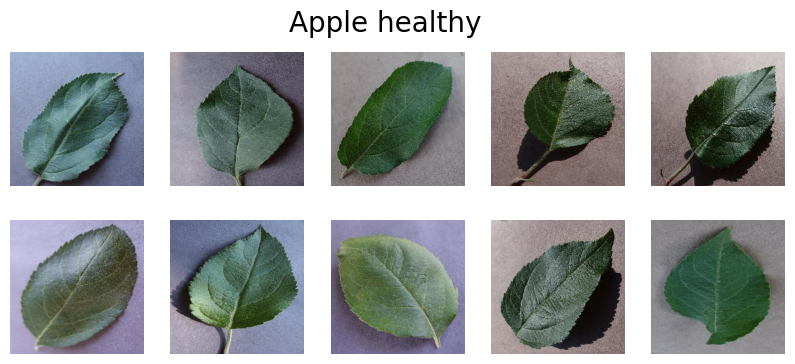

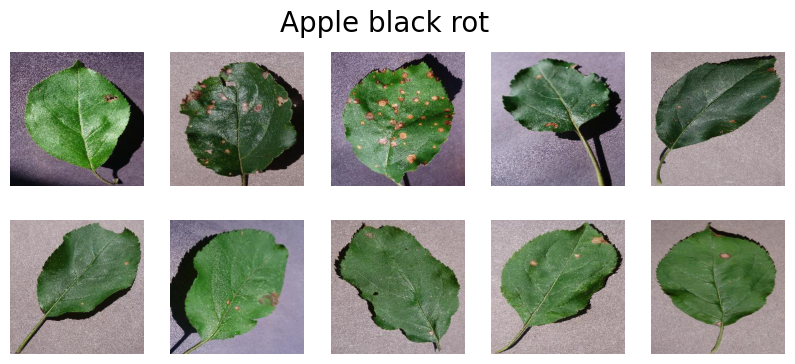

In [8]:
# plot some images in a grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

plot_images(images_0, "Apple healthy")
plot_images(images_1, "Apple black rot")

## Load model

In [9]:
model = nn.Sequential(
    *vgg16(weights=VGG16_Weights.DEFAULT).features, 
    torch.nn.Flatten(start_dim=1)
)

model.to(device) # model = pointer, for tensors: copy on other device
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
# # Es kommt drauf an, ob man nen Batch an Daten nimmt oder nur eine Instanz! [wegen Flatten layer start_dim!!]
# print("batch Image shape", X.size())
# print("Image shape", X[0].size())
# summary(model, (3, 256, 256))

## Transform features with model

## Train-Test split

In [11]:
# split data into train and test with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
with torch.no_grad():
    X_representation_train = model(X_train).to("cpu")
    X_representation_test = model(X_test).to("cpu")
    torch.cuda.empty_cache()

print(X_representation_train.shape)

torch.Size([160, 32768])


# Predicting classes from images

## Fit the model

In [12]:
# # fit model
images_0_train = X_representation_train[y_train == 0]
images_1_train = X_representation_train[y_train == 1]
mean_0 = images_0_train.sum(dim=0) / images_0_train.size(0)
mean_1 = images_1_train.sum(dim=0) / images_1_train.size(0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()
print(w.size())
print(w.get_device(), X_train.get_device())
print(images_0_train.get_device())

# For Standardizing purposeses
X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)

torch.Size([32768])
-1 0
-1


## Predict Scores

In [ ]:
pred_scores_train = torch.matmul(X_representation_train, w)
pred_probabilities_train = torch.sigmoid(pred_scores_train)

pred_scores_test = torch.matmul(X_representation_test, w)
pred_probabilities_test = torch.sigmoid(pred_scores_test)

# why the sigmoid = probabiliy?

# AUC

ROC AUC Score train:  0.996015625
ROC AUC Score test:  1.0


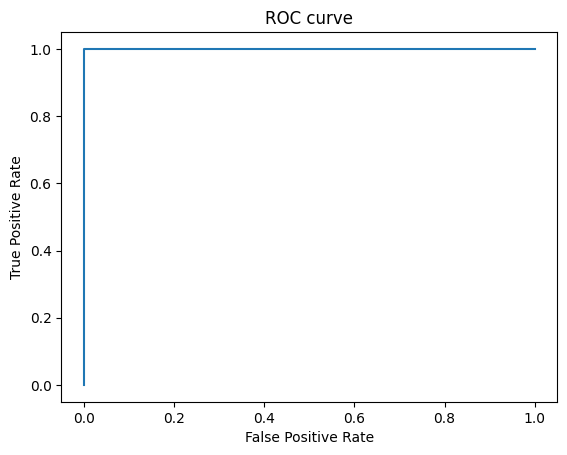

[2.0000000e+00 1.0000000e+00 9.9998212e-01 3.4838354e-09]


In [16]:
# TODO why use sigmoid "probabilities" here? it doesn't change the results probably 

print("ROC AUC Score train: ", roc_auc_score(y_train, pred_probabilities_train))
print("ROC AUC Score test: ", roc_auc_score(y_test, pred_probabilities_test))

# plot a roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities_test, drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()
print(thresholds)


# Sensitivity Analysis

Add linear layer representing the projection on the mean difference vector:

In [17]:
w_layer = torch.nn.Linear(in_features=X_representation_train.size()[1],
                          out_features=1,
                          bias=False)

# add weight layer to model to get mean difference model
model_diff = model.append(w_layer)

# with torch.no_grad():
model_diff[-1].weight = torch.nn.Parameter(w.to(device))

print(model_diff[-1].weight)

tensor(True)
Parameter containing:
tensor([ 4.7974e-05, -6.3779e-04, -9.2579e-05,  ...,  3.9492e-04,
         0.0000e+00,  2.2575e-04], requires_grad=True)


Apply Sensitivity Analysis on image:

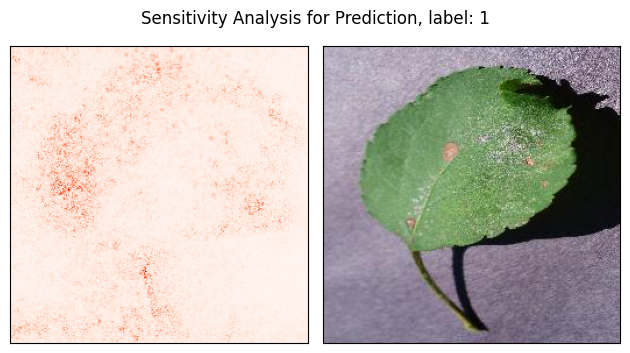

In [18]:
def get_sensitivity(model, input_data):
  output = model(input_data)
  #print(f"Predicted score: {output[0]:.2f}")
  output.backward()
  sensitivity = input_data.grad.norm(dim=1).to("cpu")
  return sensitivity


def plot_sensitivity_analysis(test_set_id=25, model=model_diff, standardize_input=False):

  img = X_test[test_set_id] # on device

  if standardize_input:
    input_data_standardized = (img - X_train_mean) / X_train_std
    input_data_standardized = input_data_standardized.unsqueeze(0)
    input_data_standardized.requires_grad = True

  input_data = img.unsqueeze(0)
  input_data.requires_grad = True


  # get sensitivity
  sensitivity = get_sensitivity(model, input_data_standardized) if standardize_input else get_sensitivity(model, input_data)

  # prepare input_data for plotting
  input_data = input_data.detach().cpu().squeeze(0)

  # plot to images
  fig, axs = plt.subplots(1,2)

  axs[0].imshow(sensitivity.squeeze(0), cmap="Reds")
  axs[1].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))

  fig.suptitle(f"Sensitivity Analysis for Prediction, label: {y_test[test_set_id]}", y=0.85)
  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
  plt.tight_layout()
  plt.show()

plot_sensitivity_analysis(test_set_id= 25, standardize_input=True)

# More robust explanations

In [ ]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.maximum(torch.zeros_like(self.og_conv.weight), self.og_conv.weight)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.maximum(torch.zeros_like(self.og_conv.bias), self.og_conv.bias)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

In [ ]:
# test biased layer with a tensor

# create Conv2d layer
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
biased_conv = BiasedLayer(conv)

# Create Artificial Input
test_input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity for both versions
conv_output = conv(test_input_data)
conv_output.backward()
conv_sensitivity = test_input_data.grad.norm(dim=1)

test_conv_output = conv(test_input_data)
test_conv_output.backward()
test_conv_sensitivity = test_input_data.grad.norm(dim=1)

# Compare
print(f"Test conv output: {conv_output},\nTransformed conv output: {test_conv_output[0]}")
print("\nTest conv Sensitivity:\n", conv_sensitivity)
print("Transformed conv output:\n", test_conv_sensitivity)

Test conv output: tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>),
Transformed conv output: tensor([[[10.]]], grad_fn=<SelectBackward0>)

Test conv Sensitivity:
 tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
Transformed conv output:
 tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])


# Customize all layers from VGG

In [ ]:
end_model = nn.Sequential()
i = 0
for layer in model_diff.children():
    if isinstance(layer, torch.nn.Conv2d) & (i != 0): # last linear layer is not considered by default
        biased_layer = BiasedLayer(layer)
        end_model.append(biased_layer)
    else:
        end_model.append(layer)
    i = 1

end_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (biased_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (biased_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (biased_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (biased_conv): Conv2d(128, 256, kernel_size=(3,

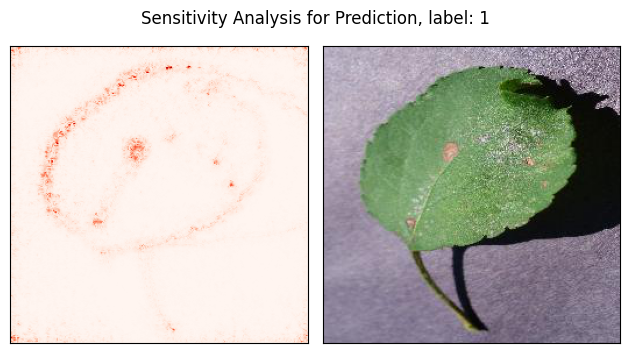

In [ ]:
plot_sensitivity_analysis(model=end_model, standardize_input=True)

In [ ]:
# compare different models
def plot_sensitivity_imgs(images):
    """ images - of shape [b, C, H, W] and stored on device """

    fig, axs = plt.subplots(len(images),4, figsize=(20, 15))

    for i, img in enumerate(images):

        # Create standardized input
        img = img.detach() # make sure that input is leaf
        input_data_standardized = (img - X_train_mean) / X_train_std
        input_data_standardized = input_data_standardized.unsqueeze(0)
        input_data_standardized.requires_grad = True

        # Regular input
        input_data = img.unsqueeze(0)
        input_data.requires_grad = True

        # get sensitivity
        sensitivity_end = get_sensitivity(end_model, input_data)
        sensitivity_end_norm = get_sensitivity(end_model, input_data_standardized)
        sensitivity_diff = get_sensitivity(model_diff, input_data)

        # prepare input_data for plotting
        input_data = input_data.detach().cpu().squeeze(0)

        if len(images) > 1:
          axs[i, 0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[i, 1].imshow(sensitivity_end.squeeze(0), cmap="Reds")
          axs[i, 2].imshow(sensitivity_end_norm.squeeze(0), cmap="Reds")
          axs[i, 3].imshow(sensitivity_diff.squeeze(0), cmap="Reds")
        else:
          axs[0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[1].imshow(sensitivity_end.squeeze(0), cmap="Reds")
          axs[2].imshow(sensitivity_end_norm.squeeze(0), cmap="Reds")
          axs[3].imshow(sensitivity_diff.squeeze(0), cmap="Reds")

        if (i == 0) & (len(images) > 1):
            axs[i, 0].set_title(f"Original Image")
            axs[i, 1].set_title(f"'Asymmetric' Gradient")
            axs[i, 2].set_title(f"'Asymmetric' Gradient (Standardized)")
            axs[i, 3].set_title(f"'Normal' Gradient")
        elif (i == 0):
            axs[0].set_title(f"Original Image")
            axs[1].set_title(f"'Asymmetric' Gradient")
            axs[2].set_title(f"'Asymmetric' Gradient (Standardized)")
            axs[3].set_title(f"'Normal' Gradient")

        #fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_sensitivity_imgs(X_test[[0, 11, 14, 16, 17]]) # images[0] ist gut # [0,14]

Output hidden; open in https://colab.research.google.com to view.

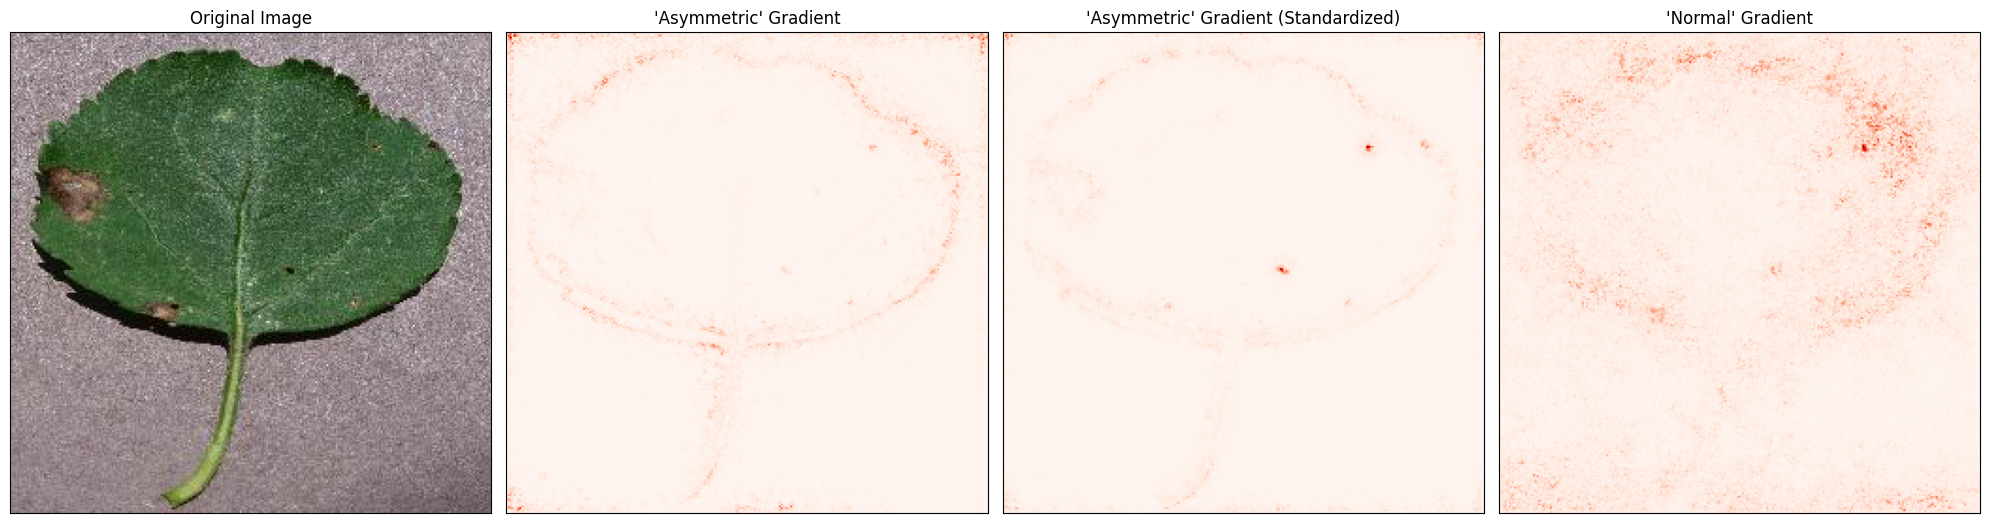

In [ ]:
plot_sensitivity_imgs(X_test[11].unsqueeze(0))

# Double check with results from pdf

torch.Size([1, 3, 256, 256])


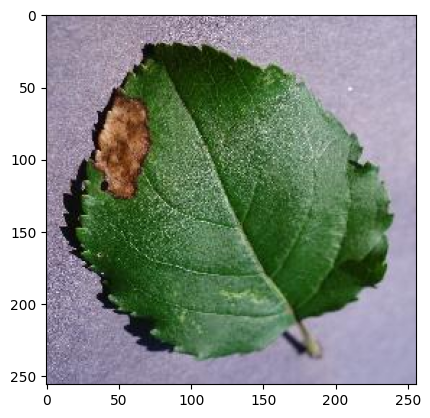

In [ ]:
import cv2
import numpy as np

#example_path = r".\data\Apple___Black_rot\image (50).jpg"
example_path = r"/content/drive/My Drive/MLLAB_Project_3/data/Apple___Black_rot/image (50).JPG"

# use imshow to open image
img = cv2.imread(example_path)
img = img[...,::-1] / 255 # convert from BGR to RGB
plt.imshow(img)
img = torch.FloatTensor(img.copy()).permute(2, 0, 1).unsqueeze(0).to(device)
img.requires_grad = True
print(img.shape)

In [ ]:
# print(img.shape, X_test[[0,1]].shape)
# print(img.is_leaf)
# for image in img:
#   print(image.detach().is_leaf) # compared to X_test looses leaf status during iterating --> add .detach() to plot function

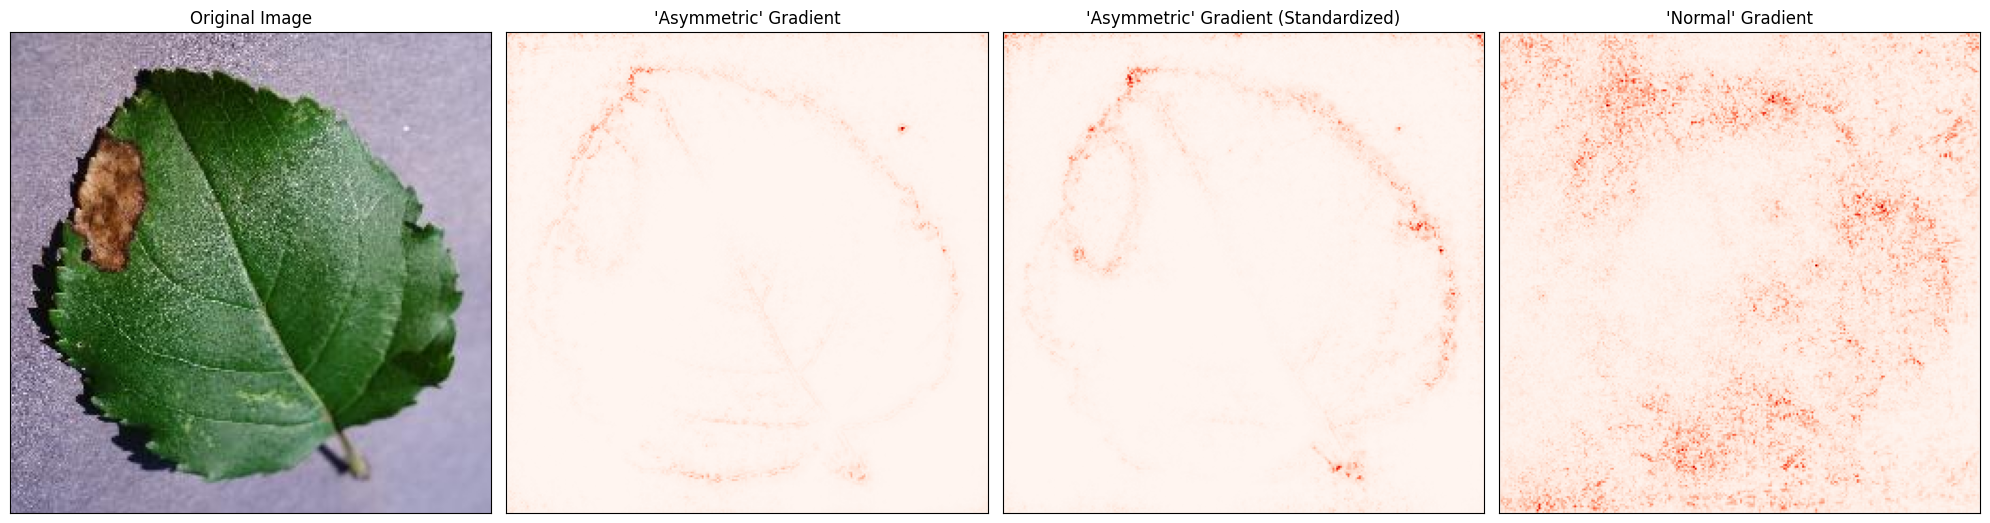

In [ ]:
plot_sensitivity_imgs(img)

# Discussion
Possible sources of mismatch:


## Insufficiently good pretrained neural network
- the pretext training is just not trained good enough to derive generalizable features; maybe not even for the pretext task itself
### Possible solutions:
- check model performance of pretrained model on upstream task
- try to fine-tune model on our task at hand
- check if there exist other downstream task are suitable to this approach (derive evidence that the approach might be valid)

## Improper method for extracting relevant features
- each layer of the pretext task probabely captures different aspects/features of the image
- taking the last layer may be an inacurate choice for the downstream task at hand, i.e. detecting the disease
- we can see that the contours are captured in our sensitivity analysis, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also sometimes detected)
- also, the data set might be too different from our dataset (i.e. focussing on cars, animals, etc. instead of leaves)
### Possible solutions:
- Try cutting of more layers to extract features
- Try to fine-tune on dataset at hand

## Problems with data quality
- resoultion is quite low --> model can't capture detailed structures/features are too vague
- shadows might disturbe features/introduce unwanted noise hardening the detection of structures related to the disease

### Possible solutions:
- increase resolution of images with designated machine learning models
- try to remove shadows either manually or with other machine learning models
- manually subsample images with less shadows included
- try to get images with higher resolution and/or without shadows in the picture to reduce noise

## Flawed understanding by the human of the plant disease
- disease might effect subtle areas of the plant which might be either hard to detect for a human or even unkown to humans due to its hard decetability
### Possible solutions:
- get in touch with people with domain knowledge
- double-check if there might be subtle structures changing due to the disease which might be unknown so far to the domain-experts